In [1]:
import numpy as np
import pandas as pd
import cv2, os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, MaxPool2D, Dropout, Dense, Flatten, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL, argparse

Using TensorFlow backend.


In [2]:
TRAINING_DIR = '/home/kartik/Desktop/Autonomous_driving'
DRIVING_LOG = os.path.join(TRAINING_DIR, 'driving_log.csv')
CORRECTION = 0.3

In [3]:
def load_data(directory):
    data_frame = pd.read_csv(DRIVING_LOG)
    center_images = data_frame['center']
    left_images = data_frame['left']
    right_images = data_frame['right']
    steering = data_frame['steering']
    throttle = data_frame['throttle']
    breaks = data_frame['break']
    speed = data_frame['break']
    
    return center_images, left_images, right_images, steering, throttle, breaks, speed

In [4]:
def augment_images(images, measurements, correction = 0.0):
    augmented_images = []
    augmented_measurements = []
    
    for image, measurement in zip(images, measurements):
        correct_measurement = measurement + correction
        augmented_images.append(image)
        augmented_measurements.append(correct_measurement)
        augmented_images.append(cv2.flip(image, 1))
        augmented_measurements.append(correct_measurement*-1)
        
    return augmented_images, augmented_measurements

In [5]:
def plot_fit_history(fit_history_obj):
    plt.plot(fit_history_obj.history['loss'])
    plt.plot(fit_history_obj.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [6]:
def loading_images(center_images_list, left_images_list, right_images_list):
    center_images = []
    left_images = []
    right_images = []

    for i in range(len(center_images_list)):
        center_images.append(cv2.imread(center_images_list[i]))
        left_images.append(cv2.imread(left_images_list[i]))
        right_images.append(cv2.imread(right_images_list[i]))
    
    return center_images, left_images, right_images

In [7]:
def augmenting(center_images, left_images, right_images, steering):
    augmented_center_images, augmented_center_measurements = augment_images(center_images, steering)
    augmented_left_images, augmented_left_measurements = augment_images(left_images, steering, CORRECTION)
    augmented_right_images, augmented_right_measurements = augment_images(right_images, steering, CORRECTION*-1)
    augmented_imgs = augmented_center_images + augmented_left_images + augmented_right_images
    augmented_measurements = augmented_center_measurements + augmented_left_measurements + augmented_right_measurements
    
    return augmented_imgs, augmented_measurements

In [8]:
center_images_list, left_images_list, right_images_list, steering, throttle, breaks, speed = load_data(DRIVING_LOG)

In [9]:
center_images, left_images, right_images = loading_images(center_images_list, left_images_list, right_images_list)

In [10]:
augmented_images, augmented_measurements = augmenting(center_images, left_images, right_images, steering)

In [11]:
X, Y = augmented_images, augmented_measurements
X = np.array(X)
Y = np.array(Y)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=False)

In [13]:
dictionary = {}
dictionary['train'] = ['X_train', 'Y_train']
dictionary['test'] = ['X_test', 'Y_test']

In [15]:
labels = {}
labels['X_train'] = X_train
labels['Y_train'] = Y_train
labels['X_test'] = X_test
labels['Y_test'] = Y_test

In [15]:
# def batch_generator(x, y, batch_size=100):
#     while True:
        

In [16]:
model = Sequential()
model.add(Cropping2D(cropping=((70, 25), (0, 0))))
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 225, 3)))
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dropout(0.3))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [17]:
fit_hist = model.fit(X, Y, validation_split=0.2, shuffle=True, epochs=6)
model.save('model.h5')
model.summary()

Train on 20160 samples, validate on 5040 samples
Epoch 1/6
20160/20160 [==============================] - 176s 9ms/step - loss: 0.0463 - val_loss: 0.0541
Epoch 2/6
20160/20160 [==============================] - 81s 4ms/step - loss: 0.0375 - val_loss: 0.0581
Epoch 3/6
20160/20160 [==============================] - 105s 5ms/step - loss: 0.0341 - val_loss: 0.0624
Epoch 4/6
20160/20160 [==============================] - 80s 4ms/step - loss: 0.0314 - val_loss: 0.0565
Epoch 5/6
20160/20160 [==============================] - 104s 5ms/step - loss: 0.0299 - val_loss: 0.0507
Epoch 6/6
20160/20160 [==============================] - 103s 5ms/step - loss: 0.0274 - val_loss: 0.0566
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 65, 320, 3)        0   

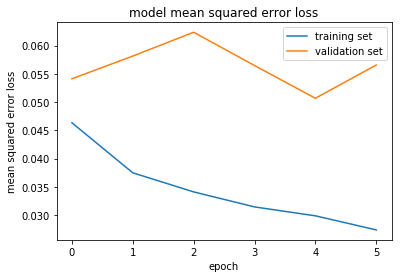

In [18]:
plot_fit_history(fit_hist)